In [1]:
# import those package we need 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # 引入 tqdm
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

Import data

In [2]:
X_train = pd.read_csv("X_train_clean.csv") 
X_test = pd.read_csv("X_test_clean.csv")
y_train = pd.read_csv("y_train_clean.csv")
y_test = pd.read_csv("y_test_clean.csv")


In [3]:
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

lightGBM

In [4]:
# LightGBM

lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_test, label = y_test, reference = lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10
}

num_round = 3000
#bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval])
bst = lgb.train(params, lgb_train, num_round, 
                valid_sets = [lgb_train, lgb_eval], 
                callbacks = [lgb.early_stopping(stopping_rounds = 200)]
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 647, number of negative: 6441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091281 -> initscore=-2.298093
[LightGBM] [Info] Start training from score -2.298093
Training until validation scores don't improve for 200 r

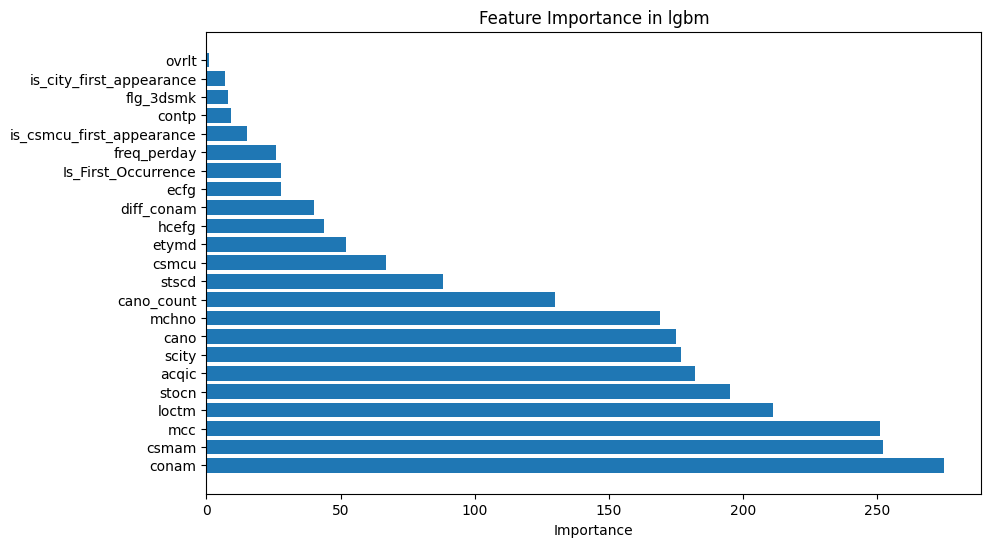

In [5]:
# Light GBM 
feature_importance_in_lgbm = bst.feature_importance(importance_type = 'split')  # 或 'gain'，取決於你想要的類型

# 獲取特徵名稱
feature_names_in_lgbm = bst.feature_name()

# 將特徵重要性轉換為 DataFrame
feature_importance_df_lgbm = pd.DataFrame({'Feature': feature_names_in_lgbm, 
                                           'Importance': feature_importance_in_lgbm}
                                           )

# 依照特徵重要性降序排序
feature_importance_df_lgbm = feature_importance_df_lgbm.sort_values(by = 'Importance', ascending = False)

# 繪製特徵重要性圖表
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df_lgbm['Feature'], 
         feature_importance_df_lgbm['Importance']
         )

plt.xlabel('Importance')
plt.title('Feature Importance in lgbm')
plt.show()

Random forest

In [6]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X_train):
    # Replace missing values with the mean of each column in: 'csmam'
    X_train = X_train.fillna({'csmam': X_train['csmam'].mean()})
    # Replace gaps forward from the previous valid value in: 'flg_3dsmk'
    X_train = X_train.fillna({'flg_3dsmk': X_train['flg_3dsmk'].ffill()})
    return X_train

X_train = clean_data(X_train.copy())
# X_train.head()

In [7]:
# random forest 

rf_classifier = RandomForestClassifier(n_estimators = 300, 
                                       random_state = 20231123, 
                                       n_jobs = 12
                                       )
rf_classifier.fit(X_train, y_train)

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300, n_jobs=12, random_state=20231123)

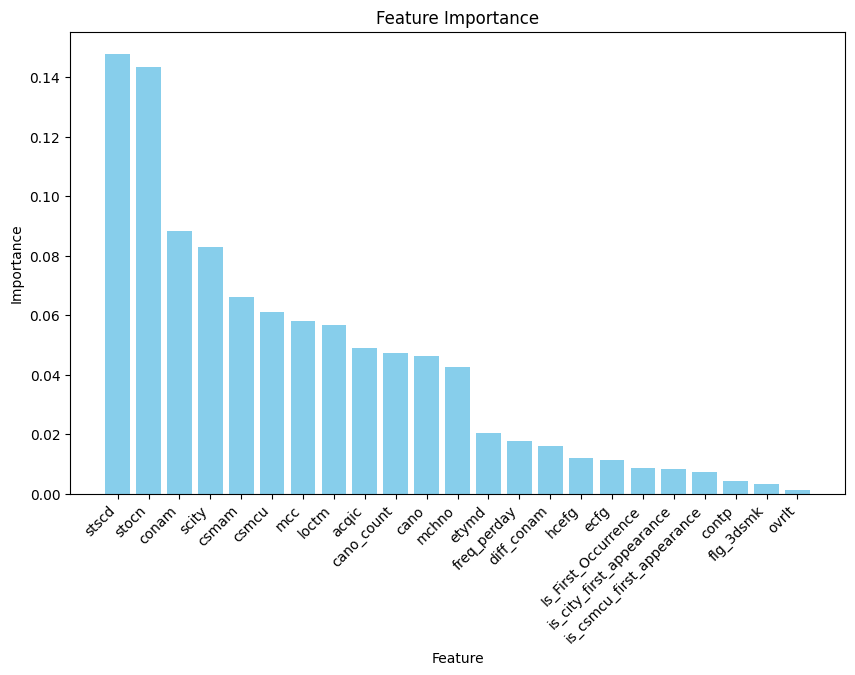

In [8]:
# Random forest 
feature_importance_in_rf = rf_classifier.feature_importances_

feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_in_rf
})

# 將 DataFrame 按照重要性排序
feature_importance_df_rf = feature_importance_df_rf.sort_values(by = 'Importance', ascending = False)

# 繪製條形圖
plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color = 'skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # 如果特徵名稱較多，可以旋轉 x 軸標籤
plt.show()

XGBoost

In [9]:
# 定義參數空間
param_dist = {
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(300, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 5)
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=12,
    seed=20231121,
    enable_categorical=True,
    tree_method='hist'
)

# 使用隨機搜索進行參數調優
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    verbose=1, 
    n_jobs=-1, 
    random_state=20231121,
    scoring='f1'
)

# 擬合模型
random_search.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=50,
                  eval_metric='auc',
                  verbose=True)

# 獲取最佳模型
best_xgb_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-auc:0.89236
[1]	validation_0-auc:0.93376
[2]	validation_0-auc:0.94005
[3]	validation_0-auc:0.95742
[4]	validation_0-auc:0.96105
[5]	validation_0-auc:0.96015
[6]	validation_0-auc:0.96182
[7]	validation_0-auc:0.95780
[8]	validation_0-auc:0.95581
[9]	validation_0-auc:0.95689
[10]	validation_0-auc:0.95750
[11]	validation_0-auc:0.95781
[12]	validation_0-auc:0.95812
[13]	validation_0-auc:0.95982
[14]	validation_0-auc:0.95891
[15]	validation_0-auc:0.95806
[16]	validation_0-auc:0.95898
[17]	validation_0-auc:0.95862
[18]	validation_0-auc:0.95866
[19]	validation_0-auc:0.95908
[20]	validation_0-auc:0.95901
[21]	validation_0-auc:0.95954
[22]	validation_0-auc:0.95849
[23]	validation_0-auc:0.95886
[24]	validation_0-auc:0.95917
[25]	validation_0-auc:0.95965
[26]	validation_0-auc:0.95926
[27]	validation_0-auc:0.96074
[28]	validation_0-auc:0.96050
[29]	validation_0-auc:0.96070
[30]	validation_0-auc:0.96015
[31]	validation_0

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-auc:0.96011
[38]	validation_0-auc:0.96009
[39]	validation_0-auc:0.96153
[40]	validation_0-auc:0.96140
[41]	validation_0-auc:0.96226
[42]	validation_0-auc:0.96208
[43]	validation_0-auc:0.96188
[44]	validation_0-auc:0.96153
[45]	validation_0-auc:0.96166
[46]	validation_0-auc:0.96184
[47]	validation_0-auc:0.96120
[48]	validation_0-auc:0.96164
[49]	validation_0-auc:0.96160
[50]	validation_0-auc:0.96180
[51]	validation_0-auc:0.96134
[52]	validation_0-auc:0.96134
[53]	validation_0-auc:0.96083
[54]	validation_0-auc:0.96063
[55]	validation_0-auc:0.96044
[56]	validation_0-auc:0.95996
[57]	validation_0-auc:0.96079
[58]	validation_0-auc:0.96085
[59]	validation_0-auc:0.96092
[60]	validation_0-auc:0.96125
[61]	validation_0-auc:0.96127
[62]	validation_0-auc:0.96083
[63]	validation_0-auc:0.96083
[64]	validation_0-auc:0.96022
[65]	validation_0-auc:0.96011
[66]	validation_0-auc:0.96007
[67]	validation_0-auc:0.96009
[68]	validation_0-auc:0.95989
[69]	validation_0-auc:0.96000
[70]	valid

#### Feature importance in 3  model

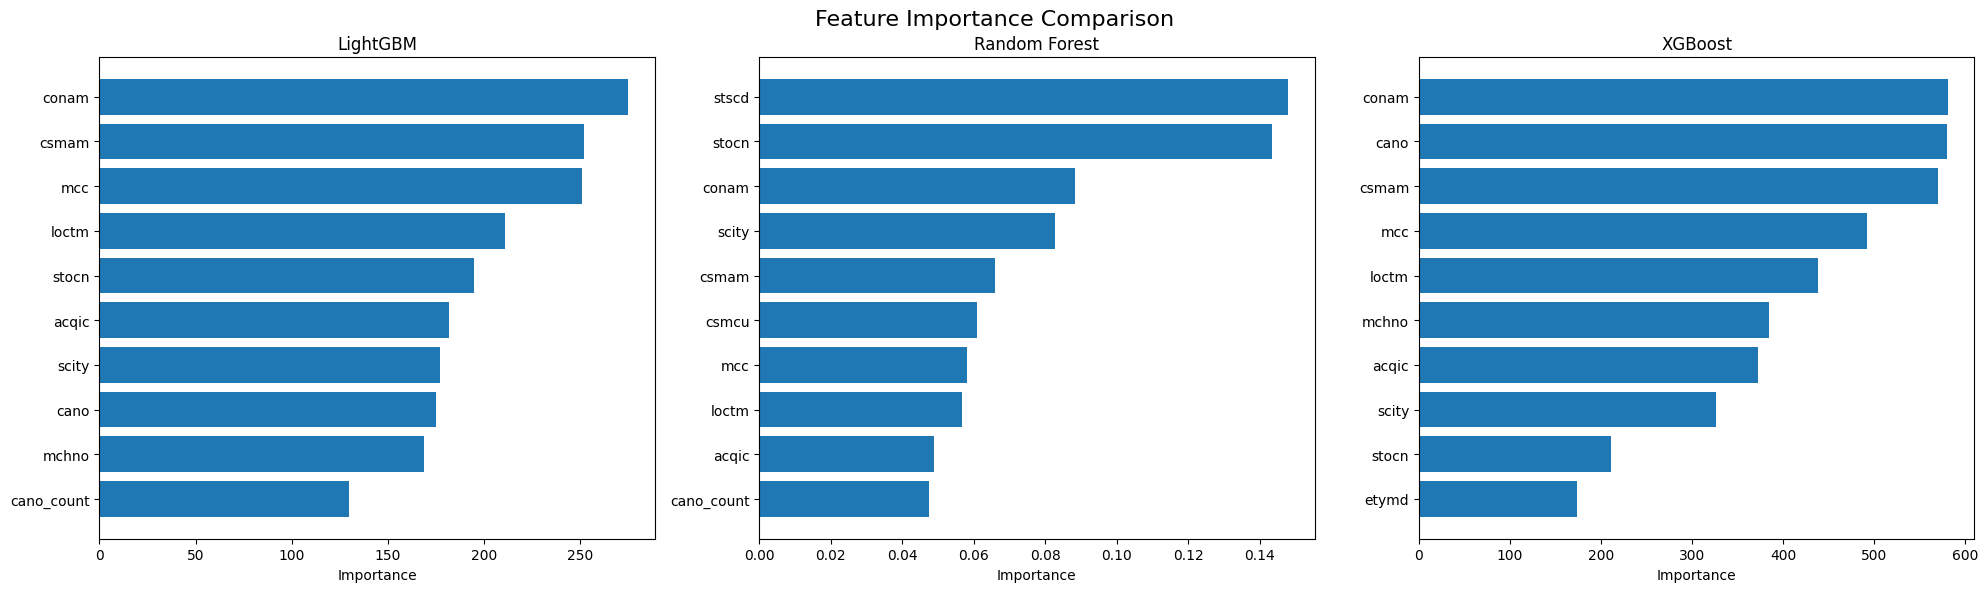

In [11]:
# LightGBM
feature_importance_df_lgbm = pd.DataFrame({
    'Feature': feature_names_in_lgbm,
    'Importance': feature_importance_in_lgbm
}).sort_values(by = 'Importance', ascending = True)

# Random Forest
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_in_rf
}).sort_values(by = 'Importance', ascending = True)

# XGBoost (使用 plot_importance 函數的數據)
fig_xgb, ax_xgb = plt.subplots(figsize=(10, 10))
plot_importance(best_xgb_model, ax = ax_xgb, importance_type = 'weight')
plt.close(fig_xgb)  # 關閉 XGBoost 的單獨圖表

# 從 ax_xgb 
xgb_importance = [patch.get_width() for patch in ax_xgb.patches]
xgb_features = [text.get_text() for text in ax_xgb.get_yticklabels()]

feature_importance_df_xgb = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_importance
}).sort_values(by = 'Importance', ascending = True)


# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))
fig.suptitle('Feature Importance Comparison', fontsize = 16)

# LightGBM
ax1.barh(feature_importance_df_lgbm['Feature'].tail(10), feature_importance_df_lgbm['Importance'].tail(10))
ax1.set_title('LightGBM')
ax1.set_xlabel('Importance')

# Random Forest
ax2.barh(feature_importance_df_rf['Feature'].tail(10), feature_importance_df_rf['Importance'].tail(10))
ax2.set_title('Random Forest')
ax2.set_xlabel('Importance')

# XGBoost
ax3.barh(feature_importance_df_xgb['Feature'].tail(10), feature_importance_df_xgb['Importance'].tail(10))
ax3.set_title('XGBoost')
ax3.set_xlabel('Importance')

# adjust layout
plt.tight_layout()
plt.subplots_adjust(top = 0.9)

plt.show()

#### Model prediction

In [12]:
y_probabilities_lgbm = bst.predict(X_test, num_iteration = bst.best_iteration)
y_probabilities_rf = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)
y_probabilities_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

Use 3 model (lgbm + rf + xgb)

LightGBM - Best Threshold: 0.39, Best F1: 0.7402
XGBoost - Best Threshold: 0.73, Best F1: 0.7350
Random Forest - Best Threshold: 0.34, Best F1: 0.7737


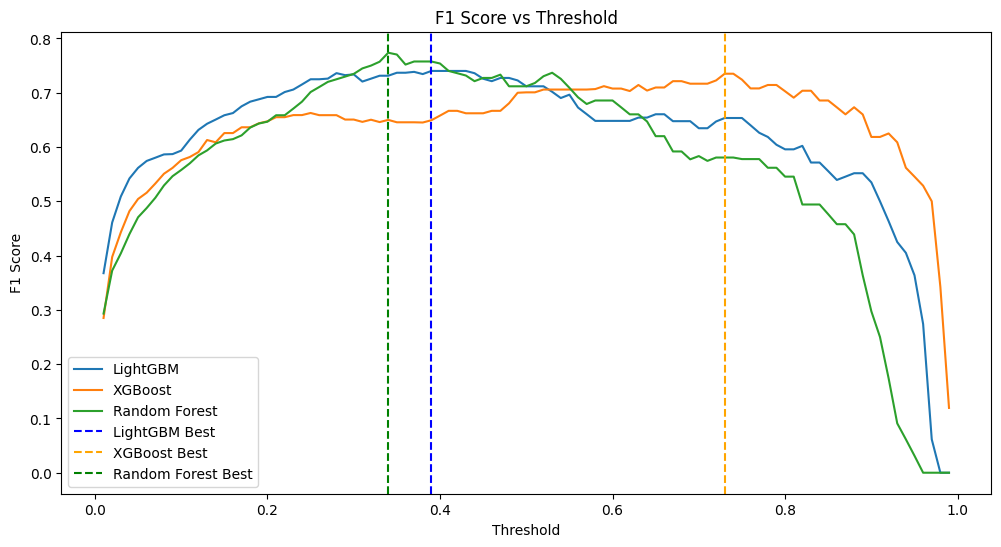

LightGBM - Precision: 0.7344, Recall: 0.7460
XGBoost - Precision: 0.7963, Recall: 0.6825
Random Forest - Precision: 0.7162, Recall: 0.8413
Best common threshold: 0.34
LightGBM (Common Threshold) - Precision: 0.6901, Recall: 0.7778, F1: 0.7313
XGBoost (Common Threshold) - Precision: 0.5361, Recall: 0.8254, F1: 0.6500
Random Forest (Common Threshold) - Precision: 0.7162, Recall: 0.8413, F1: 0.7737


In [13]:
def find_best_threshold(y_true, y_prob, thresholds):
    best_f1 = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# 使用更精細的閾值範圍
thresholds = np.arange(0.01, 1, 0.01)

# 找到每個模型的最佳閾值
best_threshold_lgbm, best_f1_lgbm = find_best_threshold(y_test.label, y_probabilities_lgbm, thresholds)
best_threshold_xgb, best_f1_xgb = find_best_threshold(y_test.label, y_probabilities_xgb, thresholds)
best_threshold_rf, best_f1_rf = find_best_threshold(y_test.label, y_probabilities_rf, thresholds)

print(f"LightGBM - Best Threshold: {best_threshold_lgbm:.2f}, Best F1: {best_f1_lgbm:.4f}")
print(f"XGBoost - Best Threshold: {best_threshold_xgb:.2f}, Best F1: {best_f1_xgb:.4f}")
print(f"Random Forest - Best Threshold: {best_threshold_rf:.2f}, Best F1: {best_f1_rf:.4f}")

# 計算並繪製各個閾值下的F1分數
f1_scores_lgbm = [f1_score(y_test.label, (y_probabilities_lgbm >= t).astype(int)) for t in thresholds]
f1_scores_xgb = [f1_score(y_test.label, (y_probabilities_xgb >= t).astype(int)) for t in thresholds]
f1_scores_rf = [f1_score(y_test.label, (y_probabilities_rf >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores_lgbm, label='LightGBM')
plt.plot(thresholds, f1_scores_xgb, label='XGBoost')
plt.plot(thresholds, f1_scores_rf, label='Random Forest')
plt.axvline(x=best_threshold_lgbm, color='blue', linestyle='--', label='LightGBM Best')
plt.axvline(x=best_threshold_xgb, color='orange', linestyle='--', label='XGBoost Best')
plt.axvline(x=best_threshold_rf, color='green', linestyle='--', label='Random Forest Best')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 計算並打印最佳閾值下的精確率和召回率
precision_lgbm = precision_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))
recall_lgbm = recall_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))

precision_xgb = precision_score(y_test.label, (y_probabilities_xgb >= best_threshold_xgb).astype(int))
recall_xgb = recall_score(y_test.label, (y_probabilities_xgb >= best_threshold_xgb).astype(int))

precision_rf = precision_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))
recall_rf = recall_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))

print(f"LightGBM - Precision: {precision_lgbm:.4f}, Recall: {recall_lgbm:.4f}")
print(f"XGBoost - Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}")

# 找到一個共同的閾值
common_thresholds = np.arange(0.3, 0.7, 0.01)  # 可以根據需要調整範圍
f1_scores_common = []

for threshold in common_thresholds:
    f1_lgbm = f1_score(y_test.label, (y_probabilities_lgbm >= threshold).astype(int))
    f1_xgb = f1_score(y_test.label, (y_probabilities_xgb >= threshold).astype(int))
    f1_rf = f1_score(y_test.label, (y_probabilities_rf >= threshold).astype(int))
    avg_f1 = (f1_lgbm + f1_xgb + f1_rf) / 3
    f1_scores_common.append(avg_f1)

best_common_threshold = common_thresholds[np.argmax(f1_scores_common)]
print(f"Best common threshold: {best_common_threshold:.2f}")

# 計算並打印使用共同閾值的結果
for model_name, y_prob in [('LightGBM', y_probabilities_lgbm), 
                           ('XGBoost', y_probabilities_xgb), 
                           ('Random Forest', y_probabilities_rf)]:
    y_pred = (y_prob >= best_common_threshold).astype(int)
    precision = precision_score(y_test.label, y_pred)
    recall = recall_score(y_test.label, y_pred)
    f1 = f1_score(y_test.label, y_pred)
    print(f"{model_name} (Common Threshold) - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Use 2 model (lgbm & rf)

LightGBM - Best Threshold: 0.39, Best F1: 0.7402
Random Forest - Best Threshold: 0.34, Best F1: 0.7737


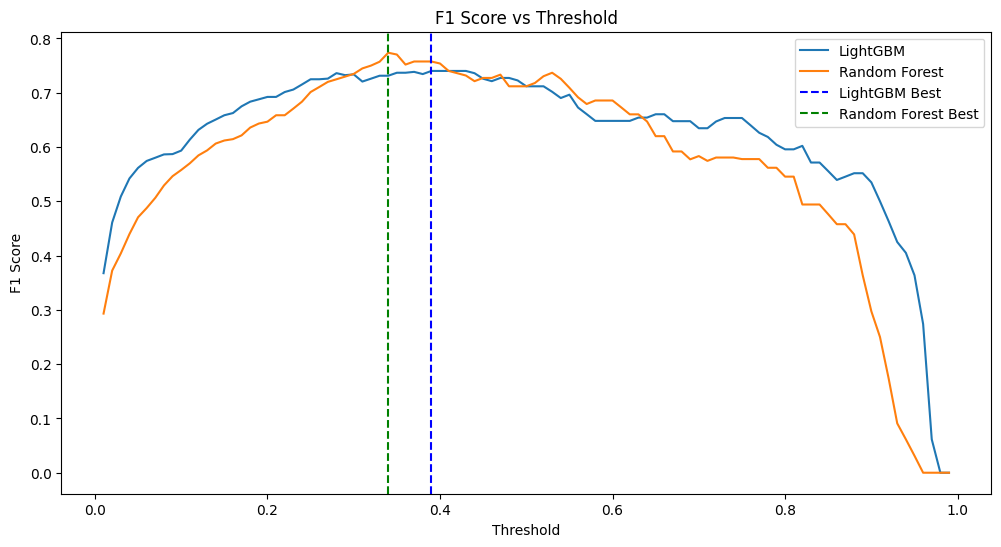

LightGBM - Precision: 0.734375, Recall: 0.746031746031746
Random Forest - Precision: 0.7162162162162162, Recall: 0.8412698412698413
Best common threshold: 0.35
LightGBM (Common Threshold) - Precision: 0.7, Recall: 0.7777777777777778, F1: 0.7368421052631577
Random Forest (Common Threshold) - Precision: 0.7222222222222222, Recall: 0.8253968253968254, F1: 0.7703703703703704


In [14]:
# def find_best_threshold(y_true, y_prob, thresholds):
#     best_f1 = 0
#     best_threshold = 0
#     for threshold in thresholds:
#         y_pred = (y_prob >= threshold).astype(int)
#         f1 = f1_score(y_true, y_pred)
#         if f1 > best_f1:
#             best_f1 = f1
#             best_threshold = threshold
#     return best_threshold, best_f1

# # 使用更精細的閾值範圍
# thresholds = np.arange(0.01, 1, 0.01)

# # 找到每個模型的最佳閾值
# best_threshold_lgbm, best_f1_lgbm = find_best_threshold(y_test.label, y_probabilities_lgbm, thresholds)
# best_threshold_rf, best_f1_rf = find_best_threshold(y_test.label, y_probabilities_rf, thresholds)

# print(f"LightGBM - Best Threshold: {best_threshold_lgbm:.2f}, Best F1: {best_f1_lgbm:.4f}")
# print(f"Random Forest - Best Threshold: {best_threshold_rf:.2f}, Best F1: {best_f1_rf:.4f}")

# # 計算並繪製各個閾值下的F1分數
# f1_scores_lgbm = [f1_score(y_test.label, (y_probabilities_lgbm >= t).astype(int)) for t in thresholds]
# f1_scores_rf = [f1_score(y_test.label, (y_probabilities_rf >= t).astype(int)) for t in thresholds]

# plt.figure(figsize=(12, 6))
# plt.plot(thresholds, f1_scores_lgbm, label='LightGBM')
# plt.plot(thresholds, f1_scores_rf, label='Random Forest')
# plt.axvline(x=best_threshold_lgbm, color='blue', linestyle='--', label='LightGBM Best')
# plt.axvline(x=best_threshold_rf, color='green', linestyle='--', label='Random Forest Best')
# plt.title('F1 Score vs Threshold')
# plt.xlabel('Threshold')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.show()

# # 計算並打印最佳閾值下的精確率和召回率
# precision_lgbm = precision_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))
# recall_lgbm = recall_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))

# precision_rf = precision_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))
# recall_rf = recall_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))

# print(f"LightGBM - Precision: {precision_lgbm}, Recall: {recall_lgbm}")
# print(f"Random Forest - Precision: {precision_rf}, Recall: {recall_rf}")

# # 找到一個共同的閾值
# common_thresholds = np.arange(0.3, 0.7, 0.01)  # 可以根據需要調整範圍
# f1_scores_common = []

# for threshold in common_thresholds:
#     f1_lgbm = f1_score(y_test.label, (y_probabilities_lgbm >= threshold).astype(int))
#     f1_rf = f1_score(y_test.label, (y_probabilities_rf >= threshold).astype(int))
#     avg_f1 = (f1_lgbm + f1_rf) / 2
#     f1_scores_common.append(avg_f1)

# best_common_threshold = common_thresholds[np.argmax(f1_scores_common)]
# print(f"Best common threshold: {best_common_threshold:.2f}")

# # 計算並打印使用共同閾值的結果
# for model_name, y_prob in [('LightGBM', y_probabilities_lgbm), 
#                            ('Random Forest', y_probabilities_rf)]:
#     y_pred = (y_prob >= best_common_threshold).astype(int)
#     precision = precision_score(y_test.label, y_pred)
#     recall = recall_score(y_test.label, y_pred)
#     f1 = f1_score(y_test.label, y_pred)
#     print(f"{model_name} (Common Threshold) - Precision: {precision}, Recall: {recall}, F1: {f1}")

#### Integrated all the result

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

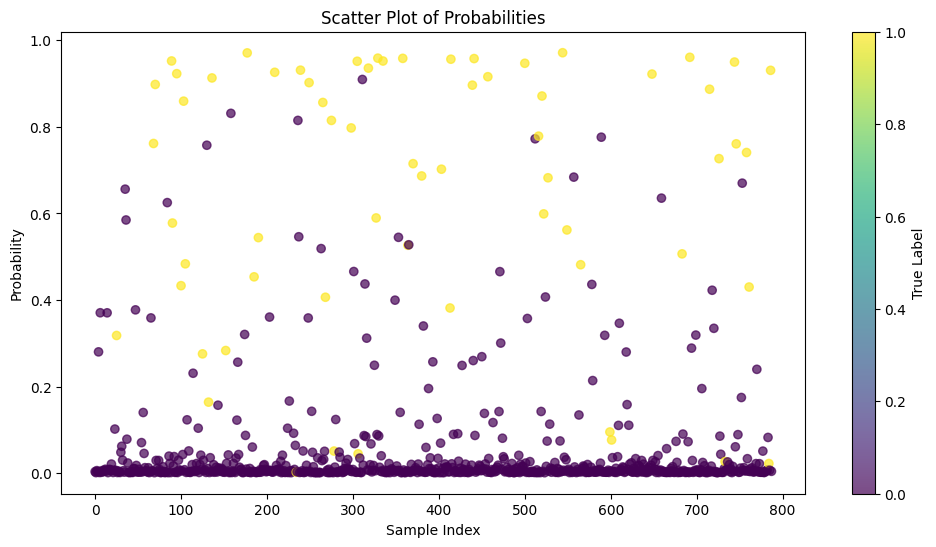

In [15]:
# Integrated all the result
y_probabilities_xgb_train = best_xgb_model.predict_proba(X_test)[:,1]

y_probabilities_lgbm_train = bst.predict(X_test, 
                                         num_iteration = bst.best_iteration
                                         )

y_probabilities_rf_train = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities = (y_probabilities_rf_train + y_probabilities_lgbm_train + y_probabilities_xgb_train) / 3


plt.figure(figsize = (12, 6))
plt.scatter(range(len(y_test)), 
            y_probabilities, 
            c =  y_test.label, 
            cmap = 'viridis', 
            alpha = 0.7
            )

plt.colorbar(label = 'True Label')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


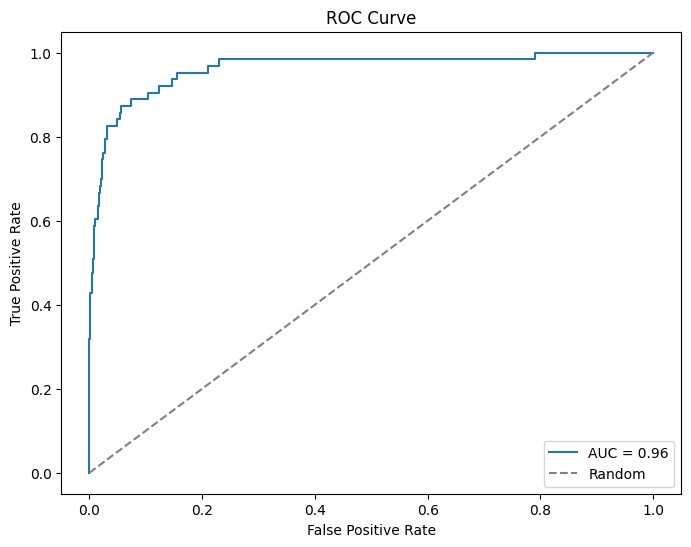

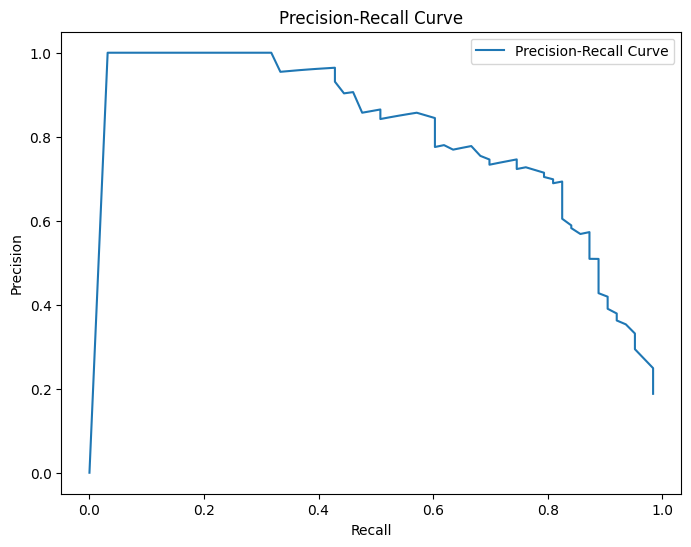

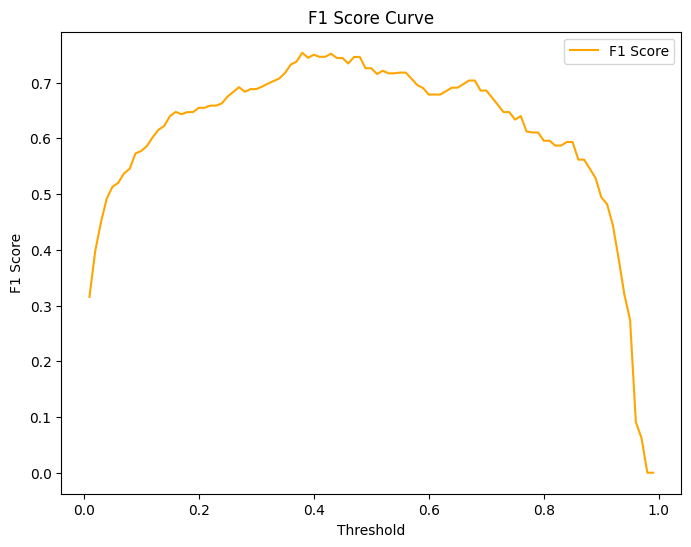

In [16]:
thresholds = np.arange(0.01, 1, 0.01)
predictions = [(y_probabilities >= threshold).astype(int) for threshold in thresholds]
precision_values = [precision_score(y_test.label, prediction) for prediction in predictions]
recall_values = [recall_score(y_test.label, prediction) for prediction in predictions]
f1_values = [f1_score(y_test.label, y_probabilities >= threshold) for threshold in thresholds]

# 計算 ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test.label, y_probabilities)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 繪製 precision-recall 曲線
plt.figure(figsize = (8, 6))
plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 score 曲線
plt.figure(figsize = (8, 6))
plt.plot(thresholds, f1_values, label='F1 Score', color='orange')
plt.title('F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [19]:
print(f"The max F1 score of emsemble result is {max(f1_values)}")
print(thresholds[np.argmax(f1_values)])

The max F1 score of emsemble result is 0.7536231884057971
0.38


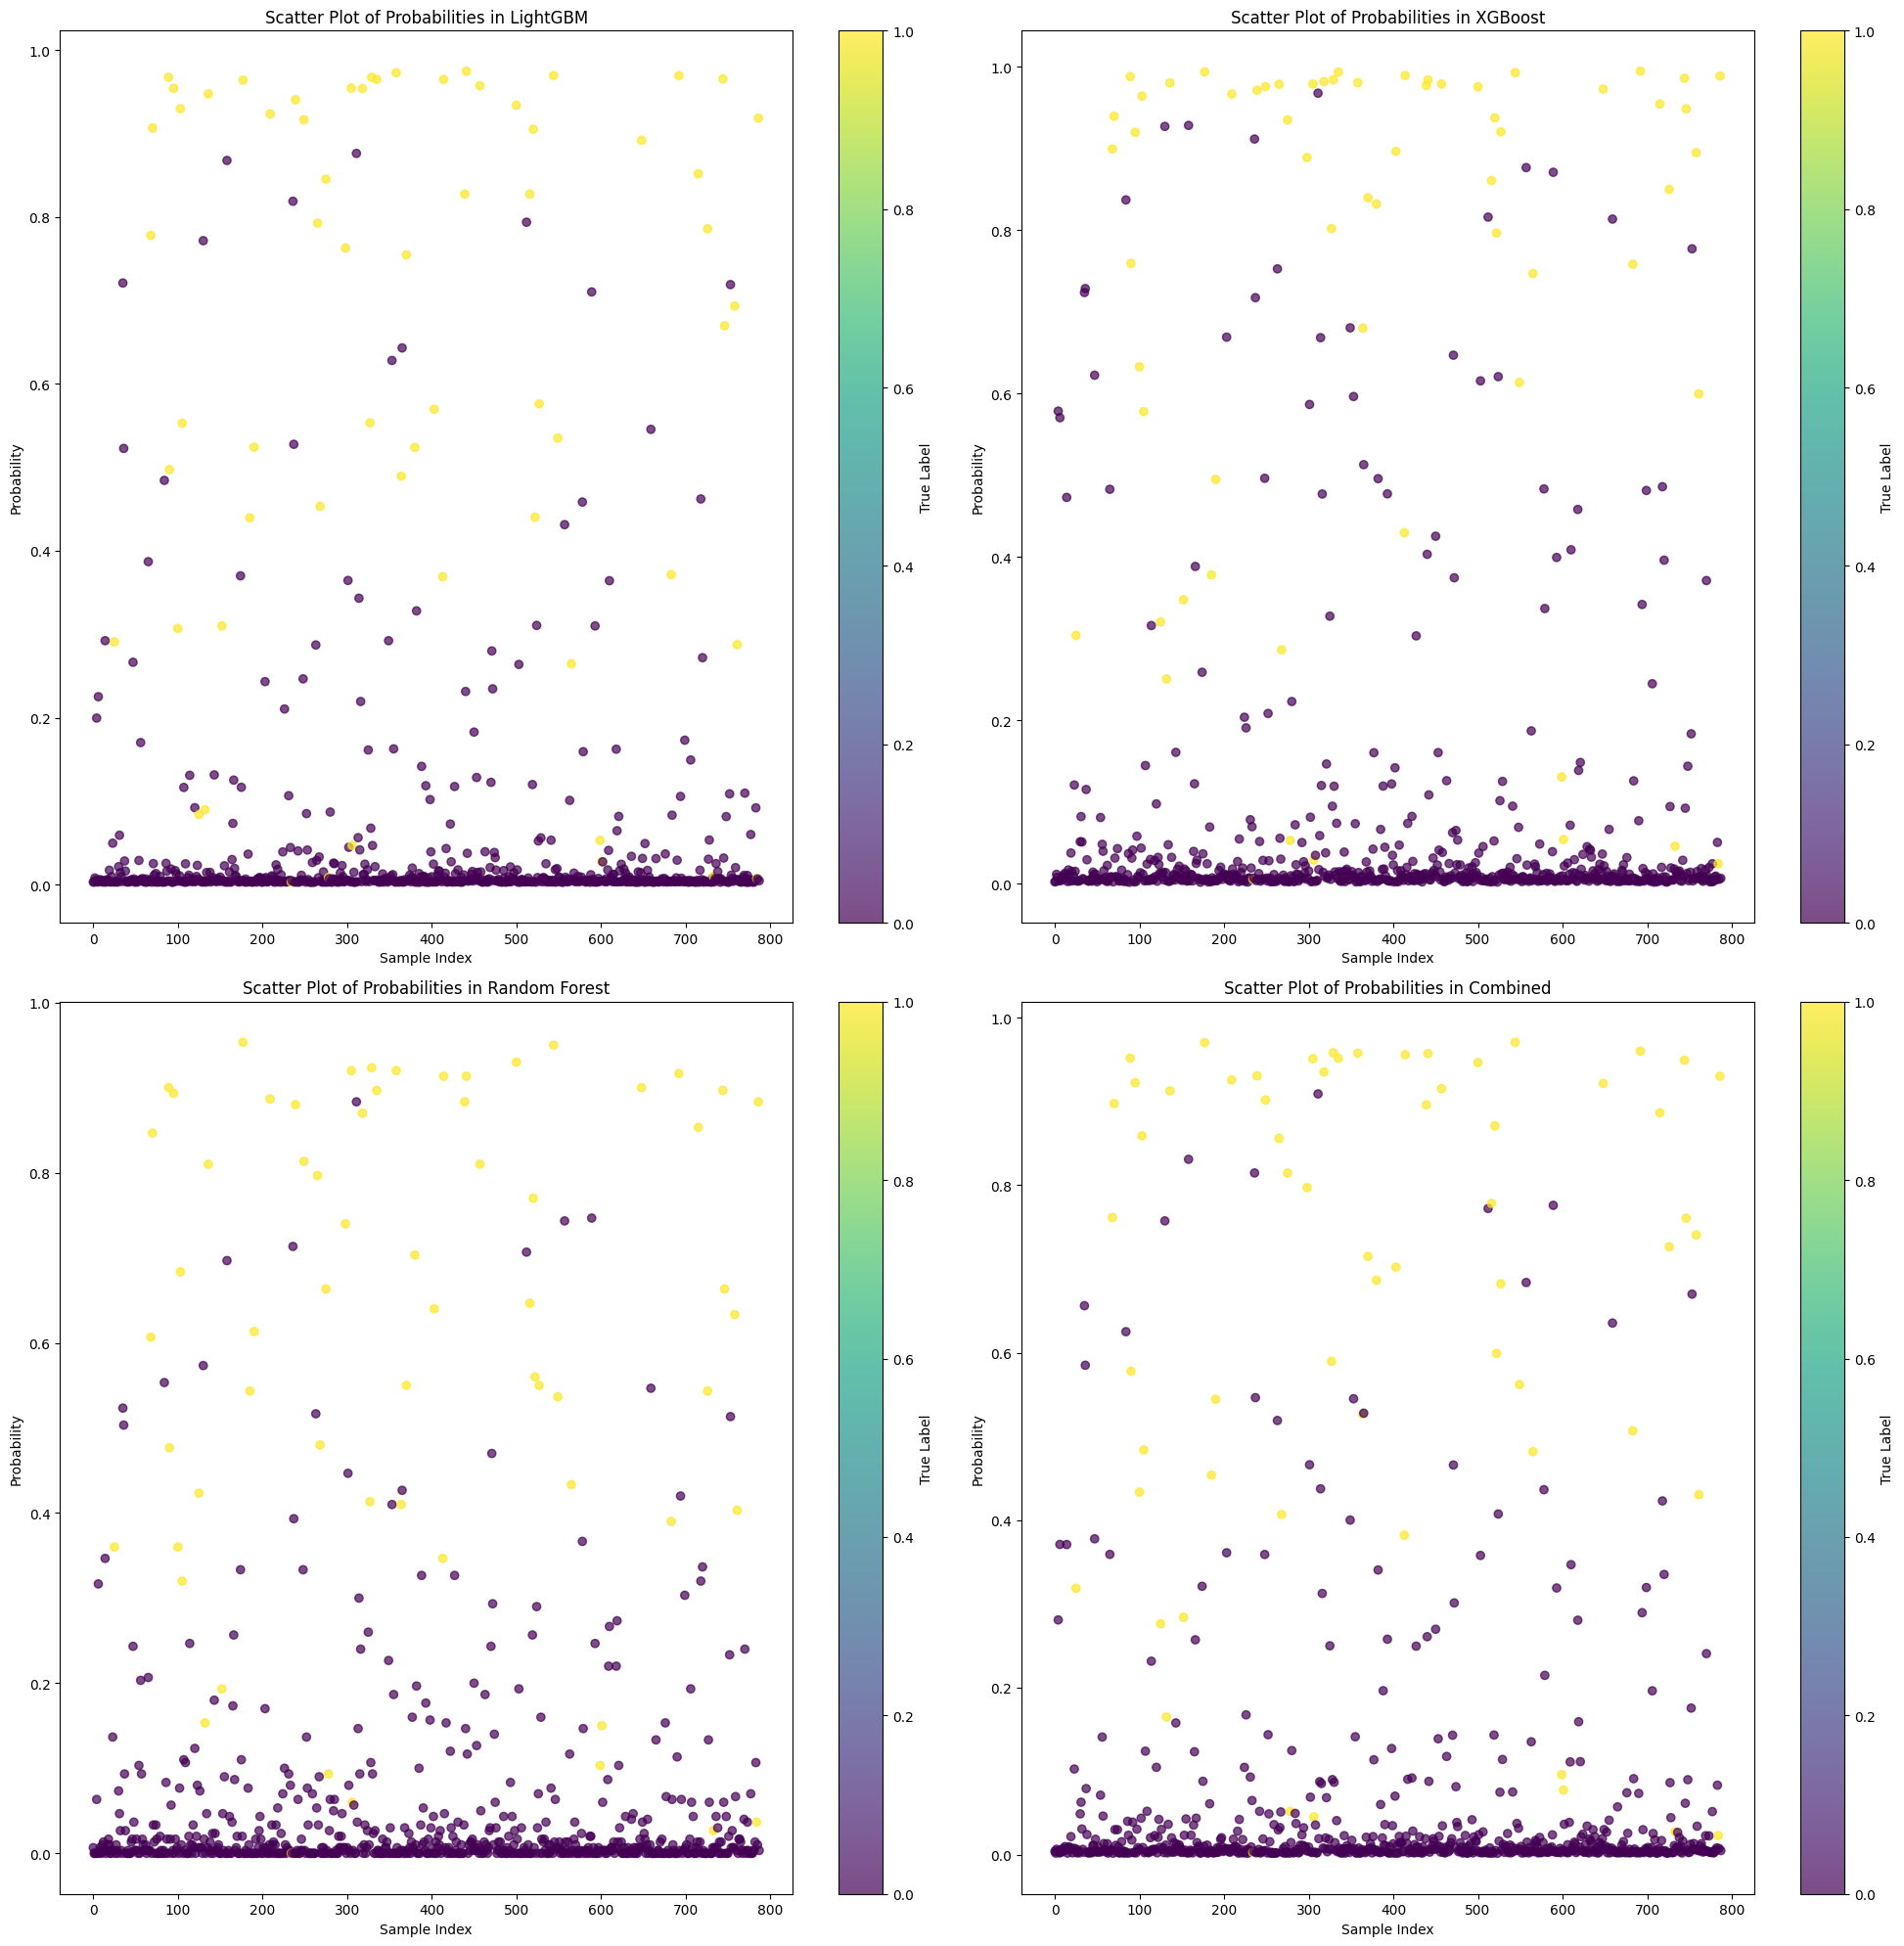

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\J

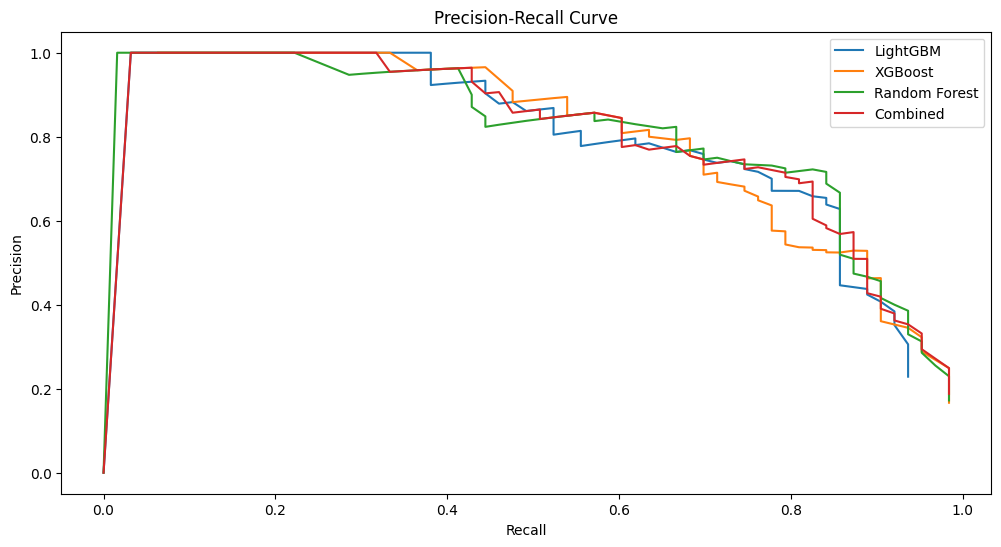

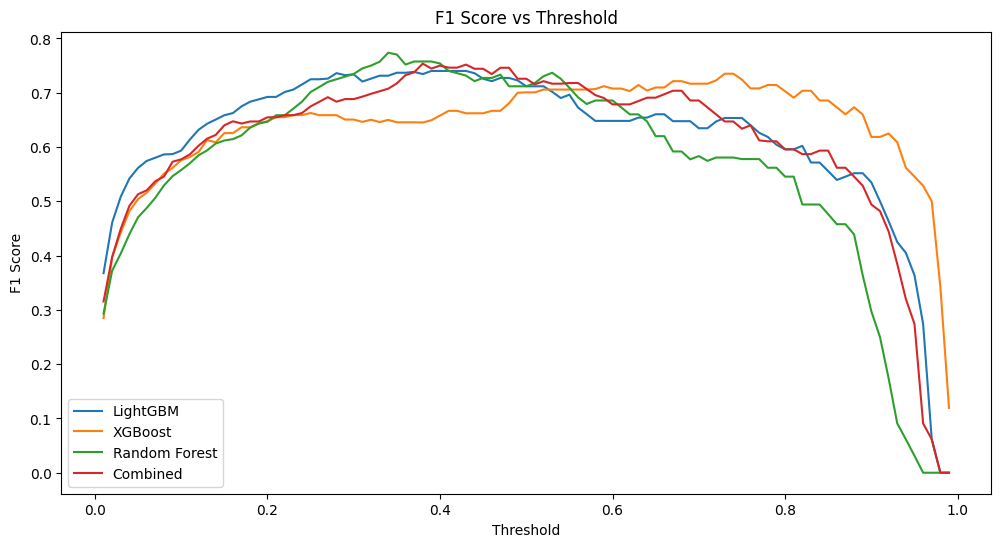

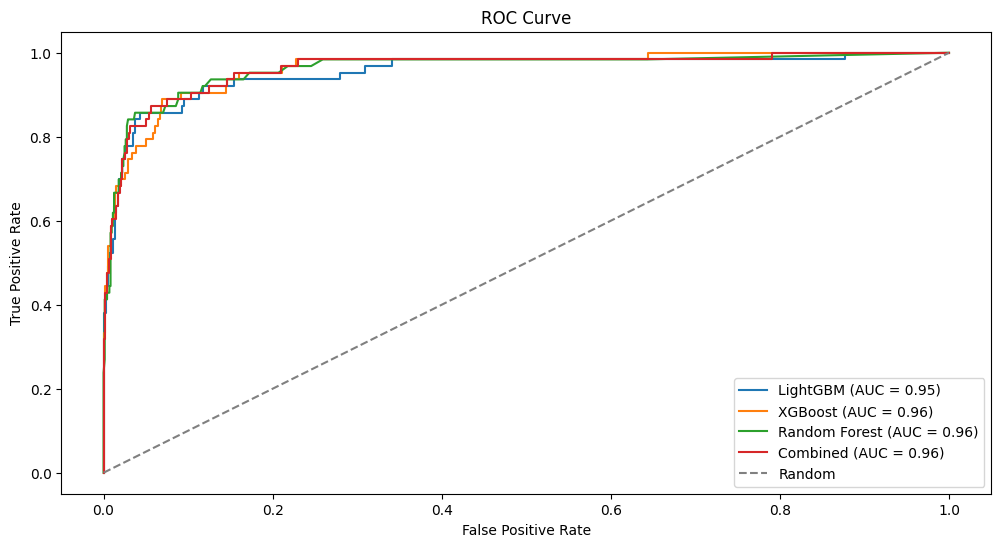

In [17]:
y_probabilities_combined = (y_probabilities_rf + y_probabilities_lgbm + y_probabilities_xgb) / 3

# 繪製散點圖
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
models = [('LightGBM', y_probabilities_lgbm), 
          ('XGBoost', y_probabilities_xgb), 
          ('Random Forest', y_probabilities_rf),
          ('Combined', y_probabilities_combined)]

for i, (model_name, y_prob) in enumerate(models):
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(range(len(y_test)), y_prob, c=y_test.label, cmap='viridis', alpha=0.7)
    ax.set_title(f'Scatter Plot of Probabilities in {model_name}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Probability')
    fig.colorbar(scatter, ax=ax, label='True Label')

plt.tight_layout()
plt.show()

# 計算評估指標的函數
def calculate_metrics(y_true, y_prob, thresholds):
    predictions = [(y_prob >= threshold).astype(int) for threshold in thresholds]
    precision_values = [precision_score(y_true, prediction) for prediction in predictions]
    recall_values = [recall_score(y_true, prediction) for prediction in predictions]
    f1_values = [f1_score(y_true, prediction) for prediction in predictions]
    return precision_values, recall_values, f1_values

# 計算各模型的評估指標
thresholds = np.arange(0.01, 1, 0.01)
metrics = {}
for model_name, y_prob in models:
    metrics[model_name] = calculate_metrics(y_test.label, y_prob, thresholds)

# 繪製 Precision-Recall 曲線
plt.figure(figsize=(12, 6))
for model_name, (precision, recall, _) in metrics.items():
    plt.plot(recall, precision, label=model_name)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 分數曲線
plt.figure(figsize=(12, 6))
for model_name, (_, _, f1) in metrics.items():
    plt.plot(thresholds, f1, label=model_name)
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 繪製 ROC 曲線
plt.figure(figsize=(12, 6))
for model_name, y_prob in models:
    fpr, tpr, _ = roc_curve(y_test.label, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## 4. Prediction on testing data

import raw X_test_pub data

In [20]:
X_test_pub = pd.read_csv("X_test_pub.csv")

In [21]:
y_probabilities_lgbm = bst.predict(X_test_pub, 
                                   num_iteration = bst.best_iteration
                                   )

y_probabilities_rf = np.mean([estimator.predict_proba(X_test_pub)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities_xgb = best_xgb_model.predict_proba(X_test_pub)[:,1]

y_probabilities = (y_probabilities_lgbm + y_probabilities_rf + y_probabilities_xgb)/3

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

In [22]:
df_raw_test = pd.read_csv("X_test.csv")

In [23]:
predictions = (y_probabilities >= 0.36).astype(int)
df_raw_test['label'] = predictions

In [24]:
# 從原始測試數據中提取 'txkey' 和 'pred' 列
df_out = df_raw_test[['txkey', 'label']]

# 創建新的數據框，只包含所需的列
df_final = pd.DataFrame({
    'index': range(len(df_out)),  # 從 0 開始的序列
    'label': df_out['label']  # 使用 'pred' 列的數據
})

# 設置數據框的索引從 1 開始
# df_final.index = range(0, len(df_final))

# 驗證結果
print(df_final.head(30))

    index  label
0       0      0
1       1      1
2       2      1
3       3      0
4       4      0
5       5      1
6       6      1
7       7      0
8       8      0
9       9      0
10     10      0
11     11      0
12     12      0
13     13      0
14     14      0
15     15      0
16     16      1
17     17      0
18     18      0
19     19      1
20     20      0
21     21      0
22     22      1
23     23      0
24     24      0
25     25      0
26     26      1
27     27      0
28     28      1
29     29      1


In [25]:
df_final.to_csv('RF+LightGBM+XG_test7.csv', 
              index = False, 
              encoding = 'utf-8'
              )